In [93]:
import pandas as pd
import numpy as np

# Cria um dataframe pandas a partir do csv fornecido
df = pd.read_csv('part-00001-12a4afec-7053-4a15-a26c-3ae39a6af37e-c000.csv')

# Transforma os dados de cada coluna para os tipos adequados.
colunas_inteiras = df.drop(['status_boolean', 'url', 'ratio_extHyperlinks', 'ratio_intHyperlinks'], axis=1).columns
colunas_float = ['ratio_extHyperlinks', 'ratio_intHyperlinks']
df[colunas_inteiras] = df[colunas_inteiras].astype(np.int64)
df[colunas_float] = df[colunas_float].astype(np.float64)
df['status_boolean'] = df['status_boolean'].astype(np.int8)
df['url'] = df['url'].astype('string')

# Ajusta o index do dataframe corretamente
df = df.reset_index()

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6350 entries, 0 to 6349
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                6350 non-null   int64  
 1   url                  6350 non-null   string 
 2   google_index         6350 non-null   int64  
 3   page_rank            6350 non-null   int64  
 4   web_traffic          6350 non-null   int64  
 5   nb_hyperlinks        6350 non-null   int64  
 6   domain_age           6350 non-null   int64  
 7   phish_hints          6350 non-null   int64  
 8   ratio_extHyperlinks  6350 non-null   float64
 9   ratio_intHyperlinks  6350 non-null   float64
 10  longest_word_path    6350 non-null   int64  
 11  longest_words_raw    6350 non-null   int64  
 12  status_boolean       6350 non-null   int8   
dtypes: float64(2), int64(9), int8(1), string(1)
memory usage: 601.6 KB
None


In [94]:
# Separa o dataset em features (X) e classes (y) e separa em treino e teste, utilizando um split de 70% treino e 30% teste
from sklearn.model_selection import train_test_split

df = df.drop(['url'], axis=1)

X = df.drop(['status_boolean'], axis=1)
y = df['status_boolean']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [95]:
# Prepara o classificador
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [96]:
# Demonsta as métricas de avaliação do modelo treinado
from sklearn.metrics import classification_report, confusion_matrix

# Nome de cada classe
target_names = ['legitimate', 'phishing']

# Classes que o modelo previu com base nos dados de teste
y_preds = clf.predict(X_test)

# Faz o classification report contendo diversas métricas de precisão do modelo
print(classification_report(y_test, y_preds, target_names=target_names))

              precision    recall  f1-score   support

  legitimate       0.94      0.95      0.94       978
    phishing       0.95      0.93      0.94       927

    accuracy                           0.94      1905
   macro avg       0.94      0.94      0.94      1905
weighted avg       0.94      0.94      0.94      1905



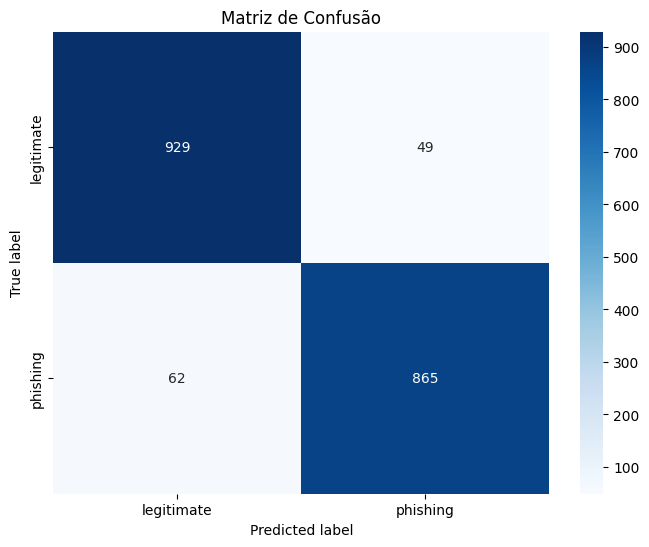

In [97]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sb

cm = confusion_matrix(y_pred=y_preds, y_true=y_test)

plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['legitimate', 'phishing'], 
            yticklabels=['legitimate', 'phishing'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Matriz de Confusão')
plt.show()

In [99]:
# Cross-validation, utilizando k=3
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=3)

print("Média dos scores da validação cruzada: ", np.mean(scores))

Média dos scores da validação cruzada:  0.938424548892915


In [ ]:
# Agora, com o modelo pronto e testado, fazemos a busca dos melhores hiperparâmetros para esse classificado
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Definindo a grid de parâmetros para teste
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Configurando o RandomizedSearchCV
clf_random = RandomizedSearchCV(estimator=clf, 
                                param_distributions=param_dist, 
                                n_iter=100,  # Número de combinações a serem testadas
                                cv=3,  # Número de folds na validação cruzada
                                verbose=2, 
                                random_state=42, 
                                n_jobs=-1)

# Treinando o modelo
clf_random.fit(X_train, y_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", clf_random.best_params_)

In [115]:
# Melhores parâmetros encontrados
best_params = {
    'n_estimators': 500,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'max_depth': 50,
    'criterion': 'entropy',
    'class_weight': 'balanced',
    'bootstrap': False
}

# Utilizando valores próximos dos encontrados para fazer um grid search mais refinado
grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

clf_grid = GridSearchCV(estimator=clf,
                        param_grid=grid,
                        cv=3,
                        scoring='f1',
                        n_jobs=-1)

# Treinando o modelo
clf_grid.fit(X_train, y_train)

# Melhores parâmetros encontrados
print("Melhores parâmetros encontrados:", clf_grid.best_params_)

Melhores parâmetros encontrados: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [116]:
# Melhores parâmetros encontrados
best_params = {
    'bootstrap': False,
    'criterion': 'entropy',
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 300
}

# Instânciando um novo classificador com os melhores parâmetros
clf = RandomForestClassifier(**best_params, random_state=42)
clf.fit(X_train, y_train)

# Classes que o modelo previu com base nos dados de teste
y_preds = clf.predict(X_test)

# Faz o classification report contendo diversas métricas de precisão do modelo
print(classification_report(y_test, y_preds, target_names=target_names))

              precision    recall  f1-score   support

  legitimate       0.94      0.95      0.94       978
    phishing       0.94      0.94      0.94       927

    accuracy                           0.94      1905
   macro avg       0.94      0.94      0.94      1905
weighted avg       0.94      0.94      0.94      1905



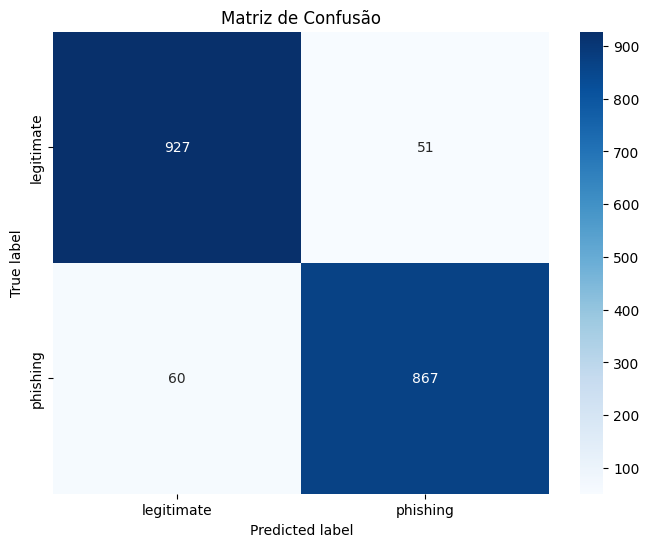

In [118]:
# Matriz de confusão
cm = confusion_matrix(y_pred=y_preds, y_true=y_test)

plt.figure(figsize=(8, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['legitimate', 'phishing'], 
            yticklabels=['legitimate', 'phishing'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Matriz de Confusão')
plt.show()

In [119]:
# Cross-validation, utilizando k=3
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X, y, cv=3)

print("Média dos scores da validação cruzada: ", np.mean(scores))

Média dos scores da validação cruzada:  0.9420462490612943
